<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/DeadTimeEstimatorMDC2020_thresholds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init and cuts definition

In [7]:
!pip install -q hist
!pip install -q uproot
!pip install -q mplhep
!pip install -I -q git+https://github.com/oksuzian/mu2etools.git
from mu2etools import utils, cuts

import hist
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import uproot

fCE='drive/MyDrive/root_files_cry5/nts.mu2e.CeEndpointMix2BBSignal.MDC2020w_perfect_v1_0.tka'
fCRY5lo='drive/MyDrive/root_files_cry5/nts.mu2e.CosmicCRYloOnSpillSignal.MDC2020w_perfect_v1_0.tka'
fCRY5hi='drive/MyDrive/root_files_cry5/nts.mu2e.CosmicCRYhiOnSpillSignal.MDC2020w_perfect_v1_0.tka'

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)

import mplhep as hep
hep.style.use('ATLAS')  # or ATLAS/LHCb2

  Preparing metadata (setup.py) ... done
Mounted at /content/drive


#Copy the data over

In [2]:
if False:
  !apt-get install krb5-user
  !wget https://authentication.fnal.gov/krb5conf/SL7/krb5.conf
  import os
  os.environ['KRB5_CONFIG'] = 'krb5.conf'
  !kinit oksuzian@FNAL.GOV
  !scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/nts.mu2e.CosmicCRYhiOnSpillSignal.MDC2020w_perfect_v1_0.tka drive/MyDrive/root_files_cry5/
  !scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/nts.mu2e.CosmicCRYloOnSpillSignal.MDC2020w_perfect_v1_0.tka drive/MyDrive/root_files_cry5/
  !scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/nts.mu2e.CeEndpointMix2BBSignal.MDC2020w_perfect_v1_0.tka drive/MyDrive/root_files_cry5/

#init

In [8]:
TMIN = -150
TMAX = 50
PMIN_EXT = 90
PMAX_EXT = 140
PMIN_PHY = 103.85
PMAX_PHY = 105.1

#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "(deent_maxr > 450)",
    "(deent_maxr < 680)"
]
cut_tbox = " & ".join(cuts)

#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)

# Extended momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_EXT,
    "(deent_mom < %f)" % PMAX_EXT
]
cut_extmom = " & ".join(cuts)

# Physics momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_PHY,
    "(deent_mom < %f)" % PMAX_PHY,
]
cut_phymom = " & ".join(cuts)

# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "(deent_maxr > 450)"
]
cut_lbox = " & ".join(cuts)

cut_t0='(de_t0 > 650) & (de_t0 < 1625)'
#crv_live_window='((crvinfo_timeWindowStart > 475 & crvinfo_timeWindowStart < 1650) | crvinfo_timeWindowStart<1)'
crv_live_window='((crv8PEs_timeWindowStart > 475 & crv8PEs_timeWindowStart < 1650) | crv8PEs_timeWindowStart<1)'
# Outside of the coincidence time window
#crv_time = "(de_t0 < crvinfo_timeWindowStart + %d | de_t0 > crvinfo_timeWindowEnd + %d)" % (TMIN, TMAX)
crv_time = "(de_t0 < crv8PEs_timeWindowStart + %d | de_t0 > crv8PEs_timeWindowEnd + %d)" % (-TMAX, -TMIN)
# Outside of the coincidence angular window
#crv_angle = "(crvinfo_angle < %d | crvinfo_angle > %d)" % (-2.5, 2.5)
crv_angle = "(debestcrv_angle < %d | debestcrv_angle > %d)" % (-2.5, 2.5)


#crv_time = "(crvinfo_dTe < %d | crvinfo_dTe > %d)" % (TMIN, TMAX)
#crv_time = crv_time+"& ( crvinfo_dTe < %d | crvinfo_dTe > %d)" % (-100, 150)
#crv_time = crv_time+"& (de_t0 < crvinfo_timeWindowStart | de_t0> crvinfo_timeWindowEnd)" 
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_t0
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom+" & "+cut_t0
cut_phymom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_phymom+" & "+cut_t0
#cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue+" & "+cut_t0
cut_loose  = cut_lbox +" & "+cut_t0

cut_extmom_notiming = cut_extmom
#cut_extmom = cut_extmom+" & " + cut_t0+" & " + crv_live_window
#cut_current = cut_extmom+" & ("+crv_time+" | "+crv_angle+")"
cut_current = cut_extmom+" & "+crv_time

#Load dataframe

In [9]:
def make_df(trkana, tag_high, mc=True):

  df = trkana.arrays(filter_name=['evtinfo.*', 'evtinfomc.*', 'de.*', 'deent*', 'demc.*', 'demcgen.*', 'demcpri.*', 'ue.*', 'crvsummary.*', 'crvsummarymc.*', 'dequal*', 'detrkpid*', 'debestcrv*', 'debestcrvmc./*'],library="pd")
  df.columns = df.columns.str.replace('.', '_')
  df.columns = df.columns.str.replace('__', '_')
  df.columns = df.columns.str.replace('_fCoordinates_f', '')
  df.columns = df.columns.str.replace('debest', '')
  df["deent_mom"] = pow(pow(df["deent_momX"],2) + pow(df["deent_momY"],2) + pow(df["deent_momZ"],2),0.5)
  if mc:
    df["demcpri_mom"] = pow(pow(df["demcpri_momX"],2) + pow(df["demcpri_momY"],2) + pow(df["demcpri_momZ"],2),0.5)

  df['is_high'] = tag_high
  df["crv_dT"] = df["crv8PEs_timeWindowStart"] - df["de_t0"]
  df = df.fillna(-999999)
  return df

In [10]:
utils.LIVETIME_LO_CRY5 = 99.4E6
utils.LIVETIME_HI_CRY5 = 2.56E6

In [11]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
trkana = uproot.open(fCRY5hi+":TrkAnaNeg/trkana")
dfCRY5=make_df(trkana, 1)
trkana = uproot.open(fCRY5lo+":TrkAnaNeg/trkana")
dfCRY5 = dfCRY5.append(make_df(trkana, 0))
trkana = uproot.open(fCE+":TrkAnaNeg/trkana")
dfCE=make_df(trkana, -1, False)

<ipython-input-9-b4ce22053c11>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('.', '_')
<ipython-input-9-b4ce22053c11>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('.', '_')
<ipython-input-11-4287748ad3a8>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfCRY5 = dfCRY5.append(make_df(trkana, 0))
<ipython-input-9-b4ce22053c11>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings 

211.0


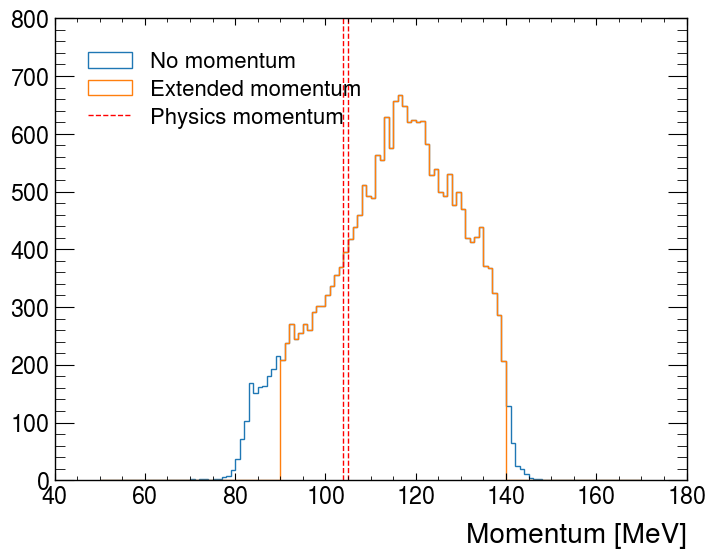

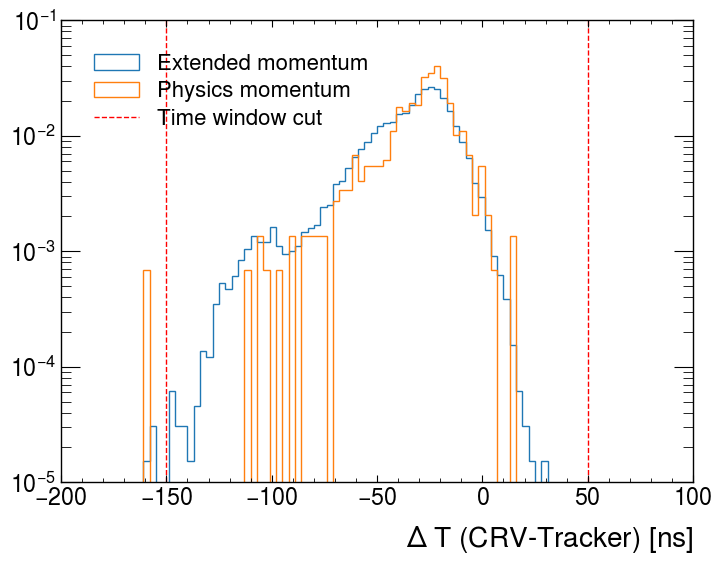

In [12]:
#neve_extmom = len(dfCRY5.query(cut_extmom))
neve_extmom = len(dfCRY5.query(cut_tbox))

neve_physmom = len(dfCRY5.query(cut_phymom))
mom_scale = neve_extmom/neve_physmom

print(mom_scale)

label = r'$\frac{P_{ext}}{P_{phy}} = %.1f$' % mom_scale
_, bins, _ = plt.hist(dfCRY5.query(cut_nomom)['deent_mom'], bins=120, range=[50, 170], histtype='step', label='No momentum');
plt.hist(dfCRY5.query(cut_extmom)['deent_mom'], bins=bins, histtype='step', label='Extended momentum');
plt.axvline(PMIN_PHY, color='r', linestyle='--', linewidth=1)
plt.axvline(PMAX_PHY, color='r', linestyle='--', label='Physics momentum', linewidth=1)
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('Momentum [MeV]')

plt.figure()
plt.hist(dfCRY5.query(cut_extmom)['crv_dT'], bins=100, range=(-200, 100), histtype='step',  density=True, label='Extended momentum');
plt.hist(dfCRY5.query(cut_phymom)['crv_dT'], bins=100, range=(-200, 100), histtype='step',  density=True, label='Physics momentum');
plt.axvline(TMIN, color='r', linestyle='--', linewidth=1)
plt.axvline(TMAX, color='r', linestyle='--', linewidth=1, label='Time window cut')
#plt.ylim(0)
#plt.yscale('log')
plt.xlabel(r'$\Delta$ T (CRV-Tracker) [ns]');
plt.legend(loc='upper left', prop={'size': 16})
plt.yscale('log')

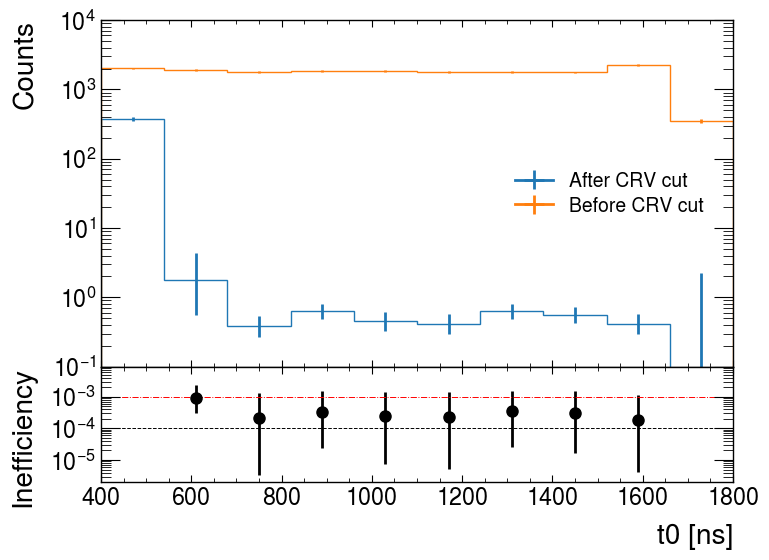

In [13]:
h = hist.Hist(
  hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
  hist.axis.Regular(10, 400, 1800, name="x", label="t0 [ns]"),
  hist.storage.Weight(),
) 

cut_tmp='ue_status <= 0 & abs(demcpri_pdg) == 13 & crvsummarymc_crvSectorType>-9999'
h.fill(cat="all", x=dfCRY5.query(cut_tbox+'&' + cut_tmp + '& is_high==0')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_LO_CRY5)
h.fill(cat="all", x=dfCRY5.query(cut_tbox+'&' + cut_tmp + '& is_high==1')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_HI_CRY5)
cut_tmp = cut_tmp +'&'+crv_time
h.fill(cat="cut", x=dfCRY5.query(cut_tbox+'&' + cut_tmp + '& is_high==0')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_LO_CRY5);
h.fill(cat="cut", x=dfCRY5.query(cut_tbox+'&' + cut_tmp + '& is_high==1')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_HI_CRY5);

import matplotlib.ticker

fig = plt.figure()
h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut", rp_denom_label="Before CRV cut", rp_ylim=[0.000002, 0.009], rp_uncert_draw_type='line');
fig.get_axes()[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.get_axes()[1].set_ylabel('Inefficiency')
fig.get_axes()[1].set_yscale('log')
fig.get_axes()[0].set_yscale('log')
fig.get_axes()[1].axhline(0.0001,color='black',ls='--', linewidth=0.7)
fig.get_axes()[1].axhline(0.001,color='red',ls='-.', linewidth=0.7)

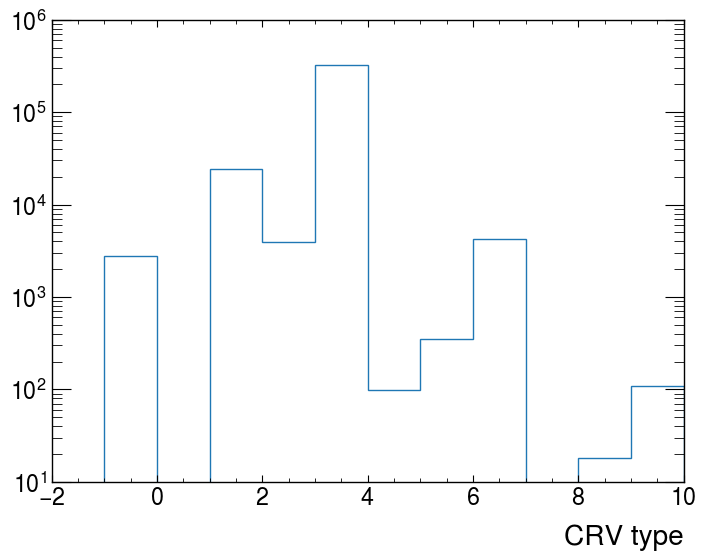

In [14]:
plt.hist(dfCRY5['crvsummarymc_crvSectorType'], range=(-1,10), bins=11, histtype='step');
plt.xlabel('CRV type');
plt.yscale('log')

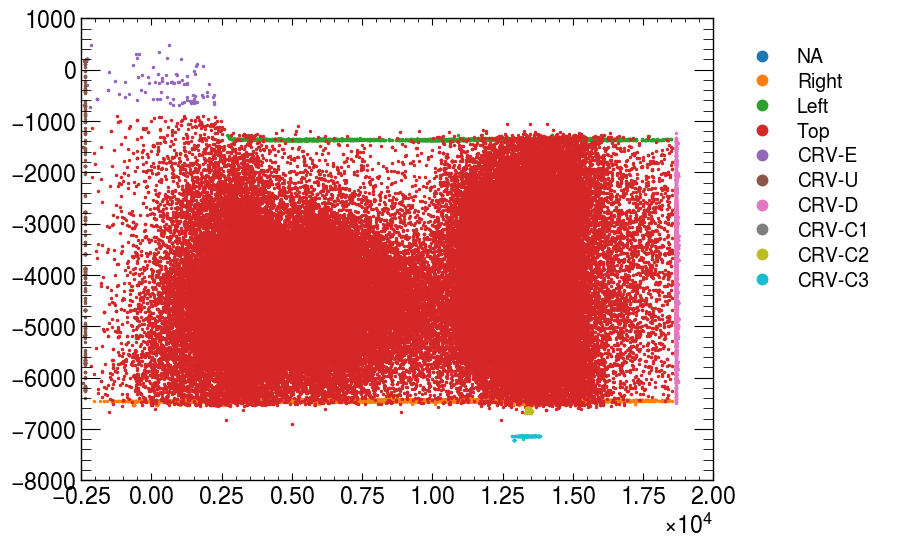

In [50]:
crvSector_list=["NA", "Right", "Left", "Top", "CRV-E", "CRV-U", "CRV-D", "CRV-C1", "CRV-C2", "CRV-C3"]

for sector in range(0,10):
  dfCRY5_ = dfCRY5.query('crvsummarymc_crvSectorType==%d'%sector)
  plt.plot(dfCRY5_['crvsummarymc_z'], dfCRY5_['crvsummarymc_x'], '.', markersize=3, label=crvSector_list[sector])
  plt.legend(bbox_to_anchor=(1, 1.0),markerscale=5)

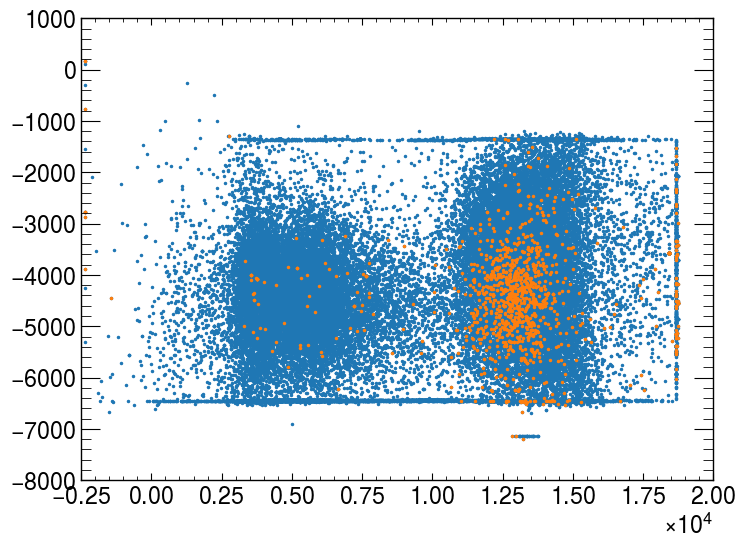

In [54]:
dfCRY5_ = dfCRY5.query('crvsummarymc_crvSectorType>0 & '+cut_tbox)
plt.plot(dfCRY5_['crvsummarymc_z'], dfCRY5_['crvsummarymc_x'], '.', markersize=3)
plt.plot(dfCRY5_.query('crv20PEs_timeWindowStart<10')['crvsummarymc_z'], dfCRY5_.query('crv20PEs_timeWindowStart<10')['crvsummarymc_x'], '.', markersize=3)

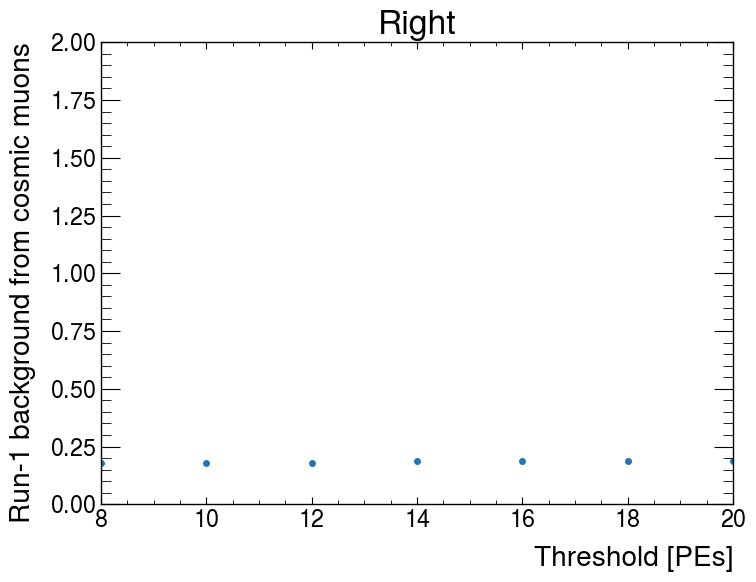

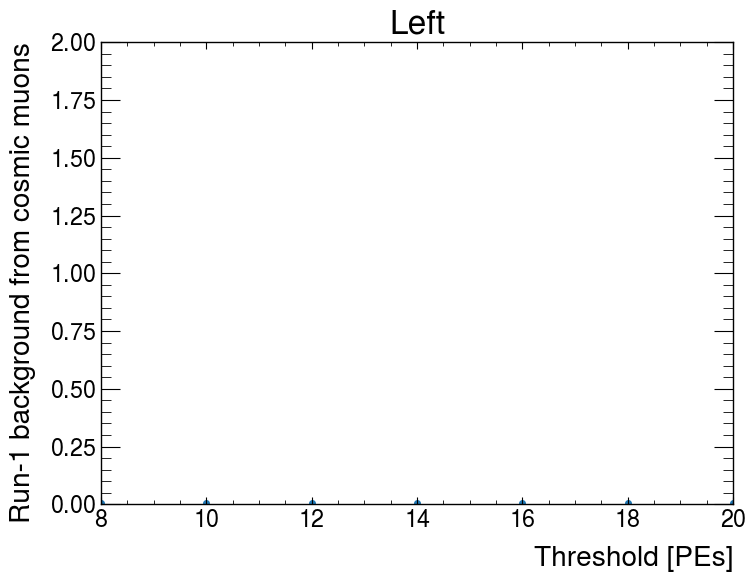

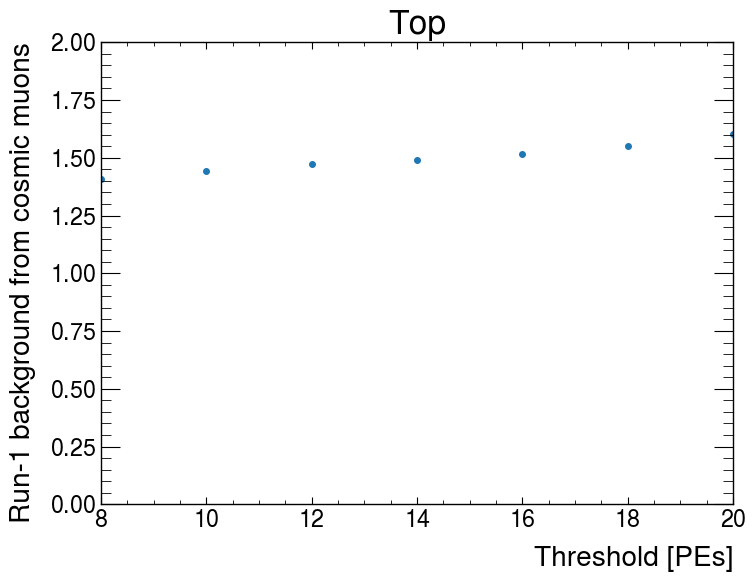

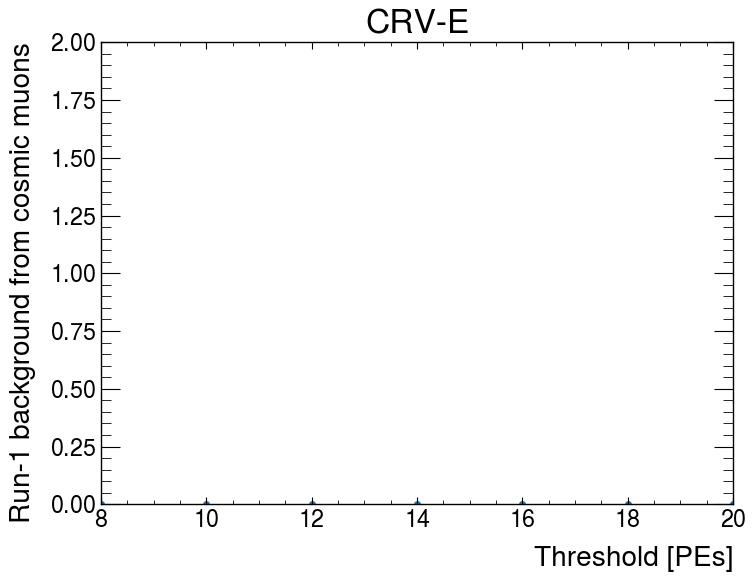

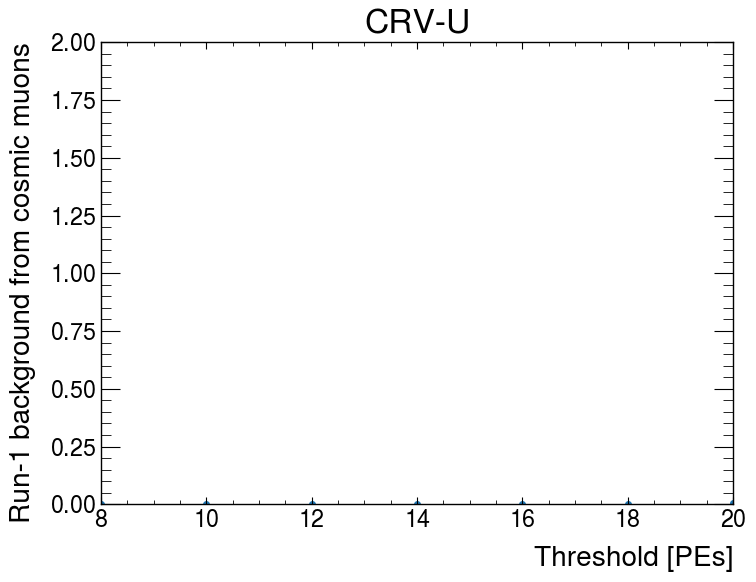

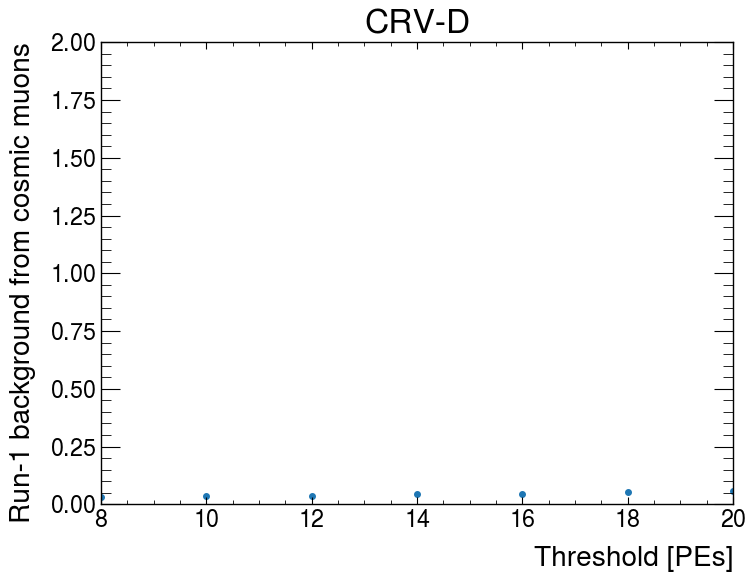

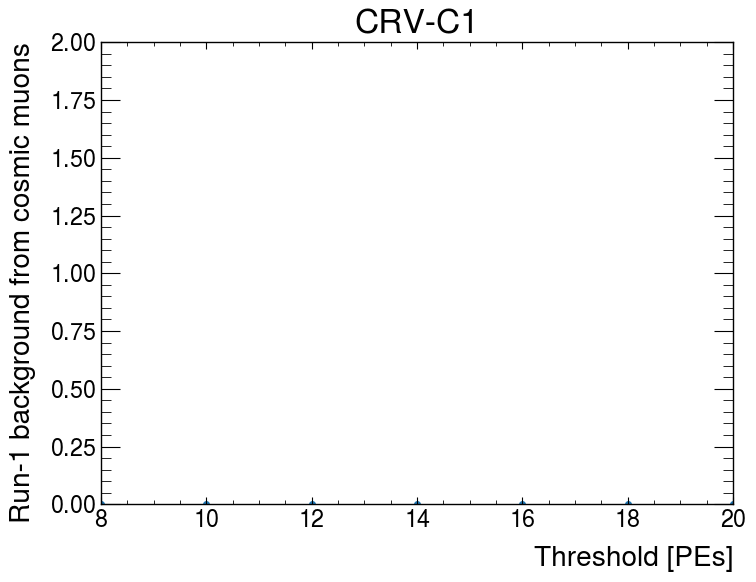

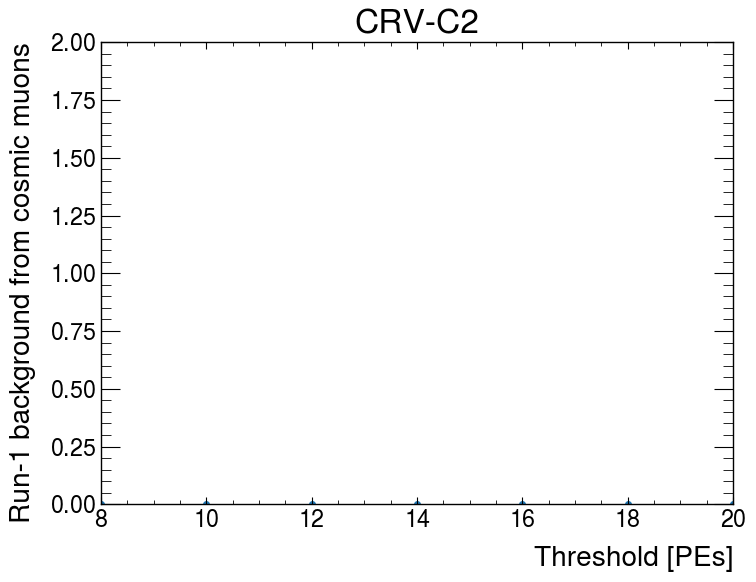

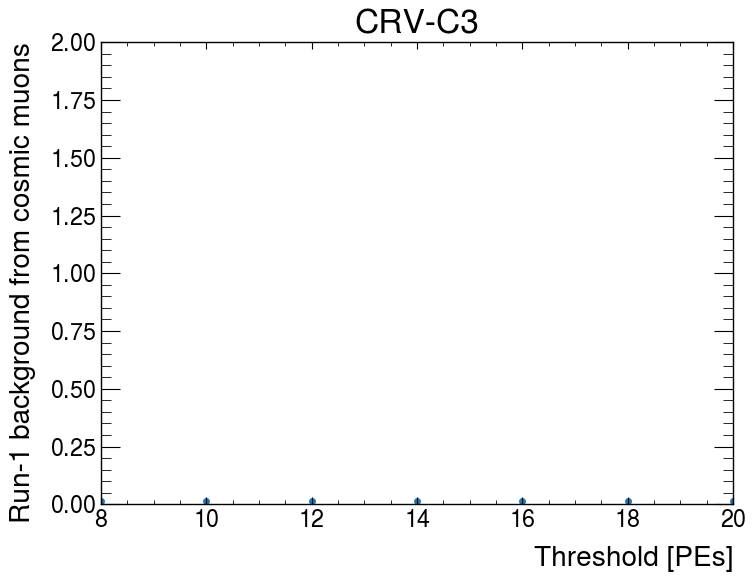

In [55]:
th_list=[8,10,12,14,16,18,20]
def plot_background(crvSector):
  bg_list=[]
  for th in th_list:
    crv_time_ = "(de_t0 < crv%dPEs_timeWindowStart + %d | de_t0 > crv%dPEs_timeWindowEnd + %d) & abs(demcpri_pdg) == 13 & crvsummarymc_crvSectorType == %d" % (th, -TMAX, th,  -TMIN, crvSector)
    bg = utils.getNormBackground(dfCRY5, cut_tbox+"&"+crv_time_, mom_scale, utils.LIVETIME_LO_CRY5, utils.LIVETIME_HI_CRY5)
    bg_list.append(bg[0])
  plt.figure()
  plt.plot(th_list, bg_list, '.')
  plt.ylabel("Run-1 background from cosmic muons");
  plt.xlabel("Threshold [PEs]");
  plt.title(crvSector_list[sector])
  plt.ylim(0,2)

for sector in range(1,10):
  plot_background(sector)


#Background estimation: production sources

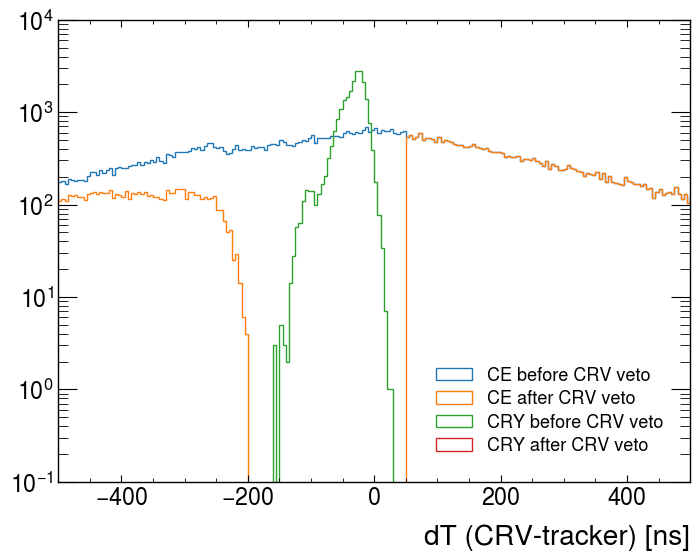

In [20]:
dfCE['crvinfo_timeWindowEnd'] = dfCE['crv8PEs_timeWindowEnd']
dfCE['crvinfo_timeWindowStart'] = dfCE['crv8PEs_timeWindowStart']
dfCE['crvinfo_dTs'] = dfCE['crv8PEs_timeWindowStart'] - dfCE['de_t0']

dfCRY5['crvinfo_timeWindowEnd'] = dfCRY5['crv8PEs_timeWindowEnd']
dfCRY5['crvinfo_timeWindowStart'] = dfCRY5['crv8PEs_timeWindowStart']
dfCRY5['crvinfo_dTs'] = dfCRY5['crv8PEs_timeWindowStart'] - dfCRY5['de_t0']

plt.hist(dfCE.query(cut_extmom+'& crvinfo_timeWindowStart>0')['crvinfo_dTs'], bins=400, range=(-1000, 1000), histtype='step', label='CE before CRV veto');
plt.hist(dfCE.query(cut_current+'& crvinfo_timeWindowStart>0')['crvinfo_dTs'], bins=400, range=(-1000, 1000), histtype='step', label='CE after CRV veto');
plt.hist(dfCRY5.query(cut_extmom+'& crvinfo_timeWindowStart>0')['crvinfo_dTs'], histtype='step', bins=400, range=(-1000, 1000), label='CRY before CRV veto');
plt.hist(dfCRY5.query(cut_current+'& crvinfo_timeWindowStart>0')['crvinfo_dTs'], histtype='step', bins=400, range=(-1000, 1000), label='CRY after CRV veto');

plt.xlabel('dT (CRV-tracker) [ns]')
plt.legend(fontsize=13)
plt.xlim(-500, 500)
plt.yscale('log')

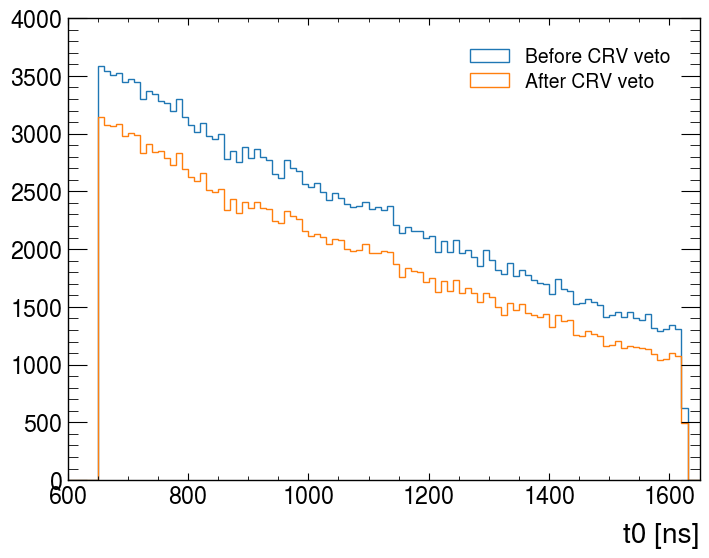

In [21]:
plt.hist(dfCE.query(cut_extmom+" & " + cut_t0+" & " + crv_live_window)['de_t0'], bins=110, range=(600, 1700), histtype='step', label='Before CRV veto');
plt.hist(dfCE.query(cut_current+" & " + cut_t0+" & " + crv_live_window)['de_t0'], bins=110, range=(600, 1700), histtype='step', label='After CRV veto');
plt.xlabel('t0 [ns]')
plt.xlim(600, 1650)
plt.legend();

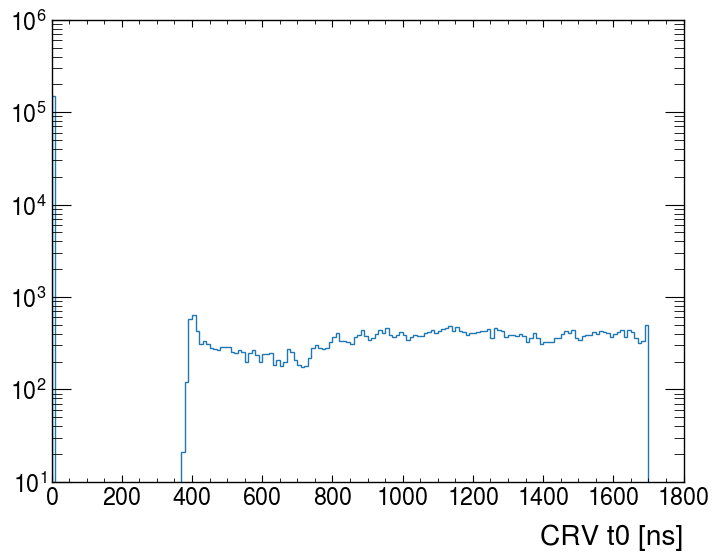

In [24]:
plt.hist(dfCE.query(cut_current+" & " + cut_t0)['crvinfo_timeWindowStart'], bins=170, range=(0, 1700), histtype='step', label='After CRV cuts');
plt.xlabel('CRV t0 [ns]')
plt.yscale('log')

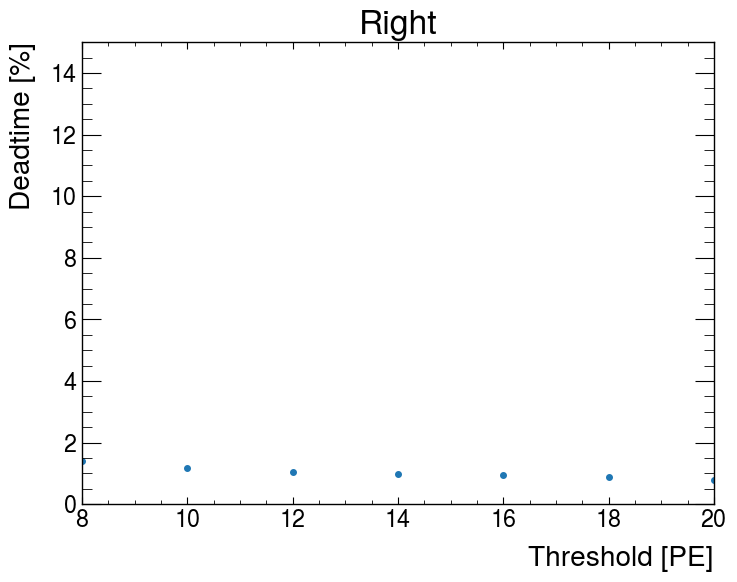

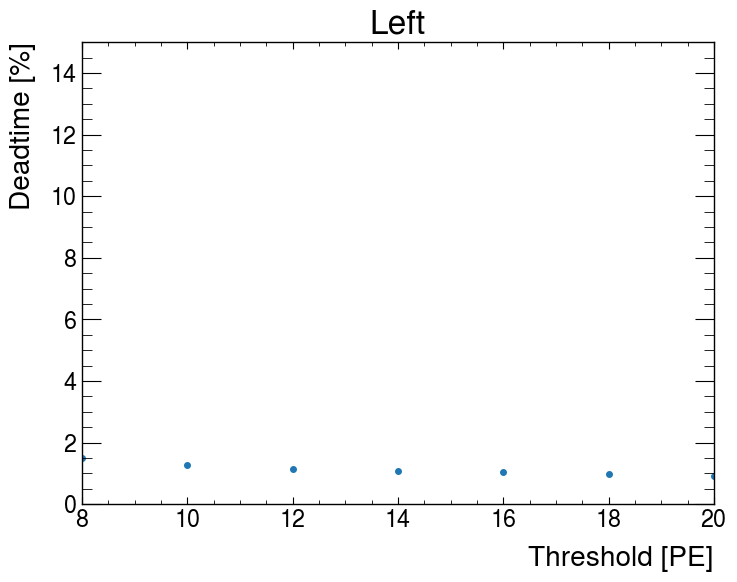

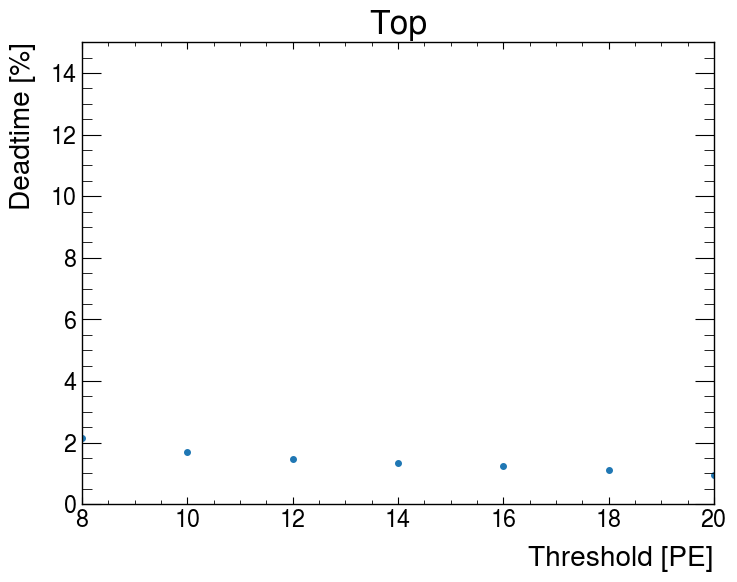

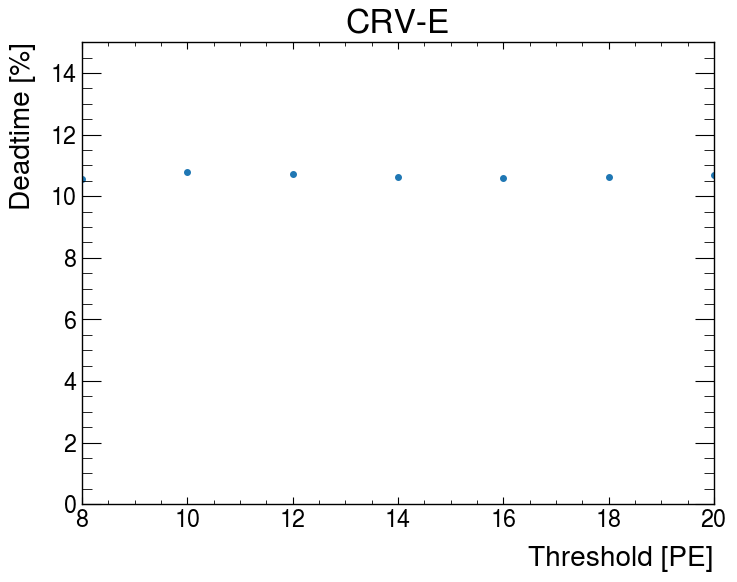

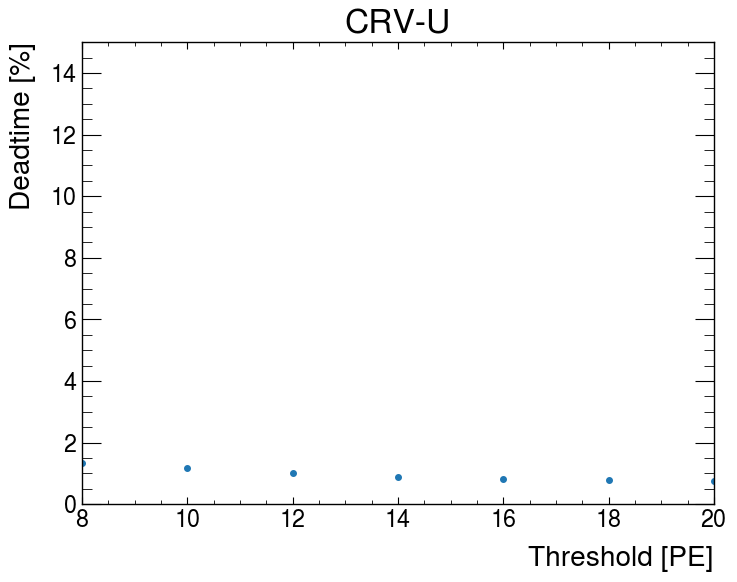

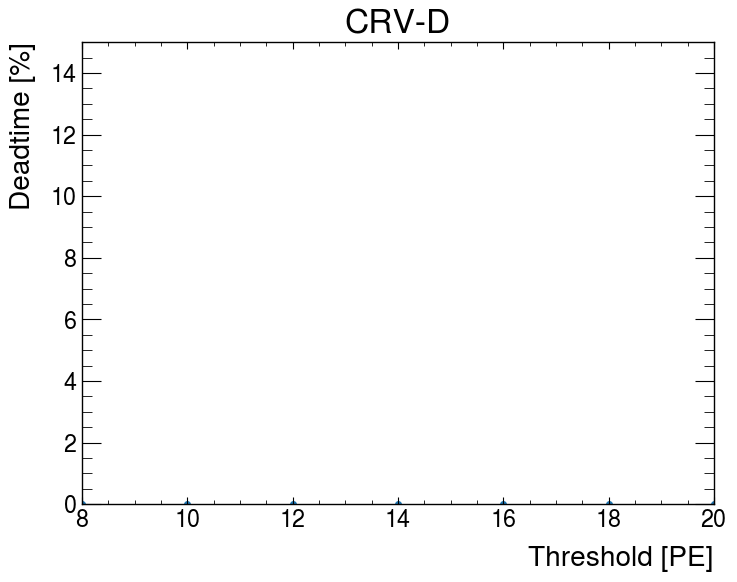

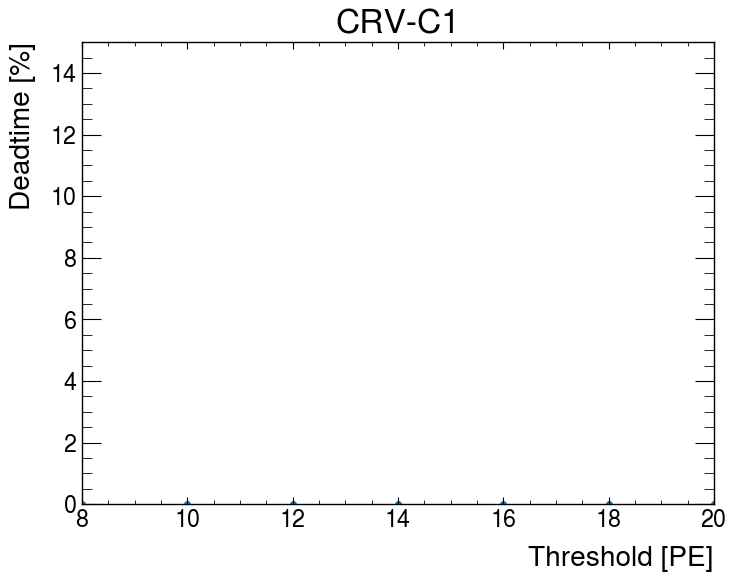

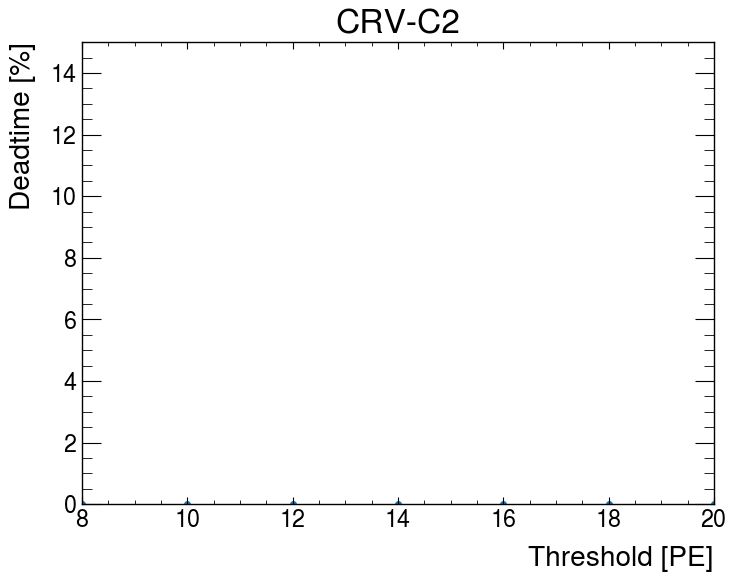

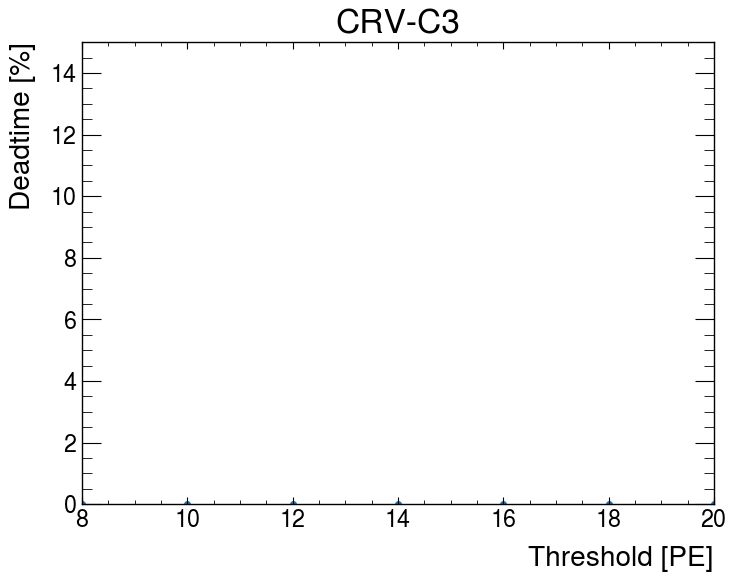

In [56]:
th_list=[8,10,12,14,16,18,20]
def plot_deadtime(crvSector):
  dead_list=[]
  for th in th_list:
    crv_time_ = "(de_t0 > crv%dPEs_timeWindowStart + %d & de_t0 < crv%dPEs_timeWindowEnd + %d) & crv%dPEs_crvSectorType == %d" % (th, -TMAX, th,  -TMIN, th, crvSector)
    dead_time = len(dfCE.query(cut_extmom+"&"+crv_time_)) / len(dfCE.query(cut_extmom))
    dead_list.append(dead_time*100)

  plt.figure()
  plt.plot(th_list, dead_list, '.')
  plt.title(crvSector_list[sector])
  plt.ylabel("Deadtime [%]")
  plt.xlabel("Threshold [PE]")
  plt.ylim(0,15)
for sector in range(1,10):
    plot_deadtime(sector)


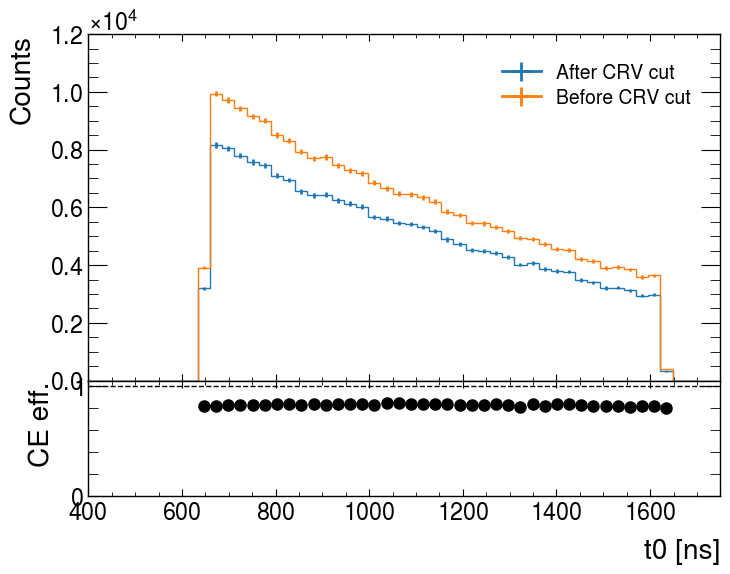

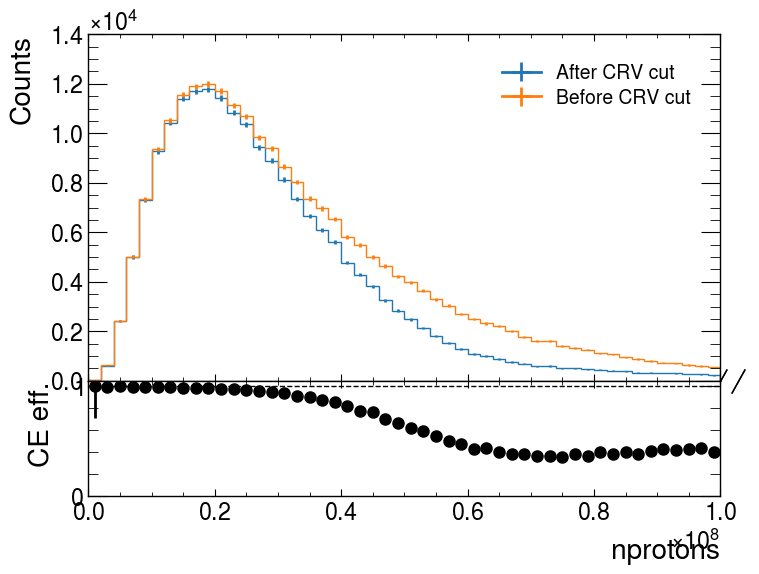

In [44]:
h = hist.Hist(
  hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
  hist.axis.Regular(50, 400, 1700, name="x", label="t0 [ns]"),
  hist.storage.Weight(),
) 

h.fill(cat="all", x=dfCE.query(cut_extmom)['de_t0'].to_numpy())
h.fill(cat="cut", x=dfCE.query(cut_current)['de_t0'].to_numpy());

fig = plt.figure()
h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut", rp_denom_label="Before CRV cut", rp_ylim=[0.0, 1.05], rp_uncert_draw_type='line');
fig.get_axes()[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
fig.get_axes()[1].set_ylabel('CE eff.')
fig.get_axes()[1].set_xlim(400,1750)

h = hist.Hist(
  hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
  hist.axis.Regular(50, 0, 1E8, name="x", label="nprotons"),
  hist.storage.Weight(),
) 

h.fill(cat="all", x=dfCE.query(cut_extmom)['evtinfomc_nprotons'].to_numpy())
h.fill(cat="cut", x=dfCE.query(cut_current)['evtinfomc_nprotons'].to_numpy());

fig = plt.figure()
h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut", rp_denom_label="Before CRV cut", rp_ylim=[0.0, 1.05], rp_uncert_draw_type='line');
fig.get_axes()[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
fig.get_axes()[1].set_ylabel('CE eff.');

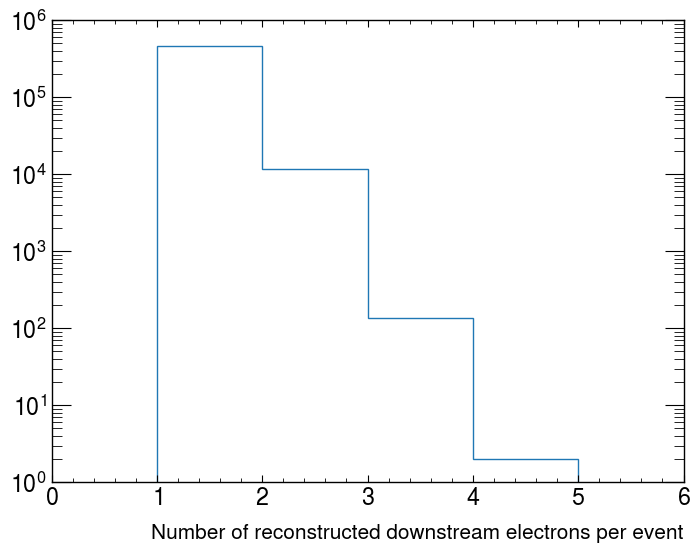

In [47]:
plt.hist(dfCE.groupby(['evtinfo_subrunid',	'evtinfo_eventid', 'evtinfomc_nprotons']).size().reset_index()[0], histtype='step', bins=6, range=(0,6));
plt.xlabel('Number of reconstructed downstream electrons per event', fontsize=15)
plt.yscale('log')